### Домашнее задание «Элементарные методы анализа временных рядов»

Взять с прошлого домашнего задания ряд (в двух вариантах - стационарный и нет) и приблизить оба эти варианта моделями из класса MA. Оценить качество и прислать соображения почему была выбрана та или иная модель

In [18]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from scipy.stats import boxcox
%matplotlib inline

In [19]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [20]:
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (4, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)

        plt.tight_layout()
    return

In [21]:
sales_of_company_x = pd.read_csv("../1. Знакомство с временными рядами/Series/monthly-sales-of-company-x-jan-6.csv")
female_births = pd.read_csv("../1. Знакомство с временными рядами/Series/daily-total-female-births-in-cal.csv")

In [22]:
all_series = {
    "Monthly sales of company X": sales_of_company_x["Count"],
    "Daily total female births in California": female_births["Count"]
}

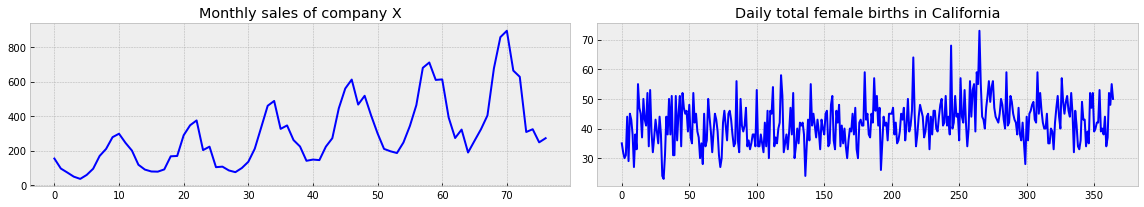

In [23]:
with plt.style.context('bmh'):
    plt.figure(figsize=(16, 8))
    layout = (3, 2)
    for i, key in enumerate(all_series.keys()):
        x = i % 2
        y = int((i - x) / 2)
        
        ts_ax = plt.subplot2grid(layout, (y, x))
        all_series[key].plot(ax=ts_ax, color='blue')
        ts_ax.set_title(key)
        
    plt.tight_layout()

##### 1. Рассмотрим временной ряд "daily-total-female-births-in-cal.csv"

In [24]:
female_births_1 = pd.read_csv("../1. Знакомство с временными рядами/Series/daily-total-female-births-in-cal.csv")['Count']

Results of Dickey-Fuller Test:
Test Statistic                  -4.808291
p-value                          0.000052
#Lags Used                       6.000000
Number of Observations Used    358.000000
Critical Value (1%)             -3.448749
Critical Value (5%)             -2.869647
Critical Value (10%)            -2.571089
dtype: float64


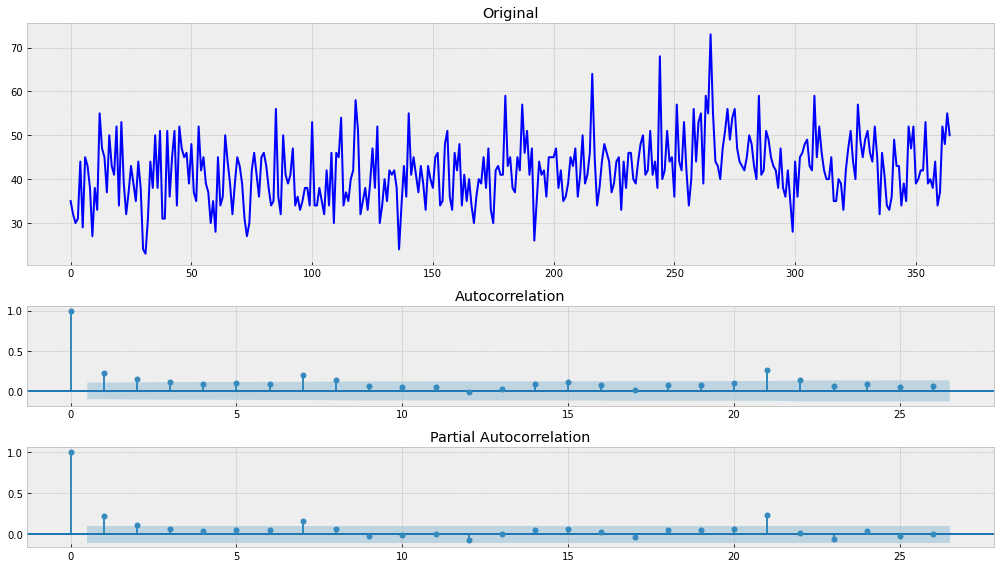

In [25]:
tsplot(female_births_1)

p-value = 0.000052, ряд стационарный, поэтому можно использовать скользящее среднее либо экспоненциальное сглаживание, т.к. для данного ряда не нужно учитывать такие временные компоненты, как тренд или сезонность

In [30]:
#Скользящее среднее

def moving_average(series, n):
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
    return series.rolling(n).mean()

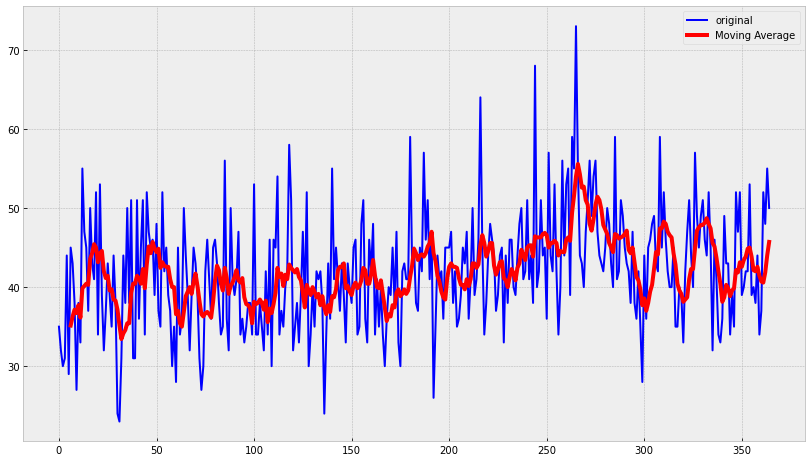

In [46]:
ser = moving_average(female_births["Count"], 7)
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(female_births["Count"], color='blue',label='original')
    plt.plot(ser, color='red', linewidth='4', label='Moving Average')
    plt.legend()

In [31]:
# взвешенная скользящая средняя

def weighted_moving_average(series, n, weights):
    if not isinstance(weights, np.ndarray):
        weights = np.array(weights)
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
    wma = series.rolling(n).apply(lambda s: (s * weights).sum() / weights.sum(), raw=True)
    return wma

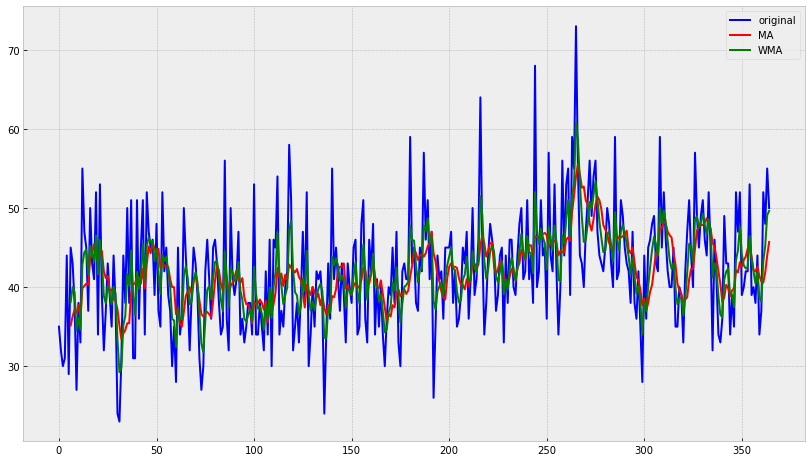

In [45]:
wma = weighted_moving_average(female_births["Count"], 7, [1,1,2,3,5,8,13])
ma = moving_average(female_births["Count"], 7)
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(female_births["Count"], color='blue',label='original')
    plt.plot(ma, color='red', linewidth='2', label='MA')
    plt.plot(wma, color='green', linewidth='2', label='WMA')
    plt.legend()

In [47]:
# Экспоненциальное сглаживание

def exponential_moving_average(series, alpha):
    result = [series[0]]
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return pd.Series(result)

In [48]:
ema = exponential_moving_average(female_births["Count"], 0.2)

In [49]:
len(ema)

365

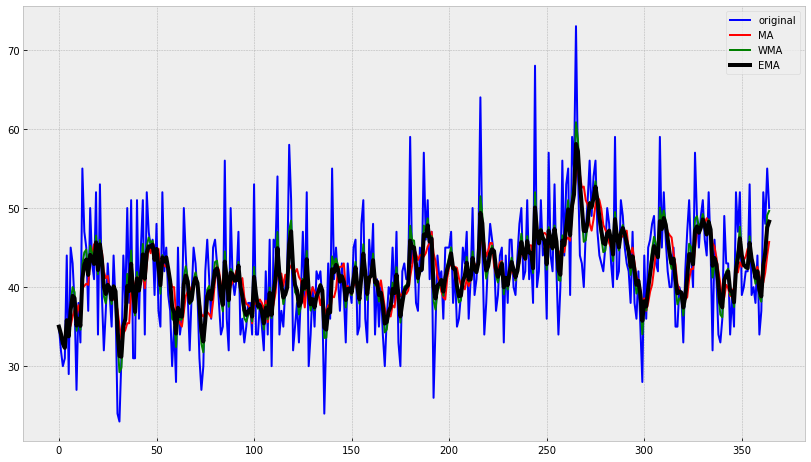

In [50]:
ema = exponential_moving_average(female_births["Count"], 0.3)
wma = weighted_moving_average(female_births["Count"], 7, [1,1,2,3,5,8,13])
ma = moving_average(female_births["Count"], 7)
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(female_births["Count"], color='blue',label='original')
    plt.plot(ma, color='red', linewidth='2', label='MA')
    plt.plot(wma, color='green', linewidth='2', label='WMA')
    plt.plot(ema, color='black', linewidth='4', label='EMA')
    plt.legend()

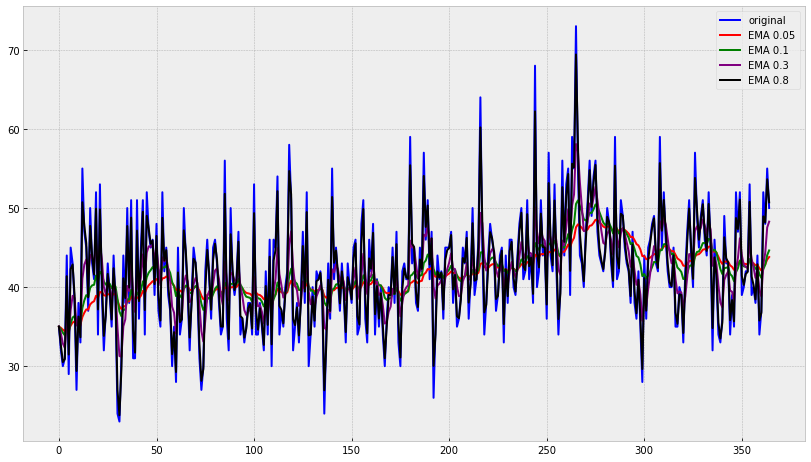

In [51]:
alphas = [0.05,0.1,0.3,0.8]
colors = ['red', 'green', 'purple', 'black']
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(female_births["Count"], color='blue',label='original')
    for i in range(len(alphas)):
        ser = exponential_moving_average(female_births["Count"], alphas[i])
        plt.plot(ser, color=colors[i], linewidth='2', label='EMA {}'.format(alphas[i]))
    plt.legend()

##### 2. Рассмотрим временной ряд “monthly-sales-of-company-x-jan-6.csv”

In [52]:
sales_of_company_x_1 = pd.read_csv("../1. Знакомство с временными рядами/Series/monthly-sales-of-company-x-jan-6.csv")['Count']

Results of Dickey-Fuller Test:
Test Statistic                  0.654715
p-value                         0.988889
#Lags Used                     12.000000
Number of Observations Used    64.000000
Critical Value (1%)            -3.536928
Critical Value (5%)            -2.907887
Critical Value (10%)           -2.591493
dtype: float64


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


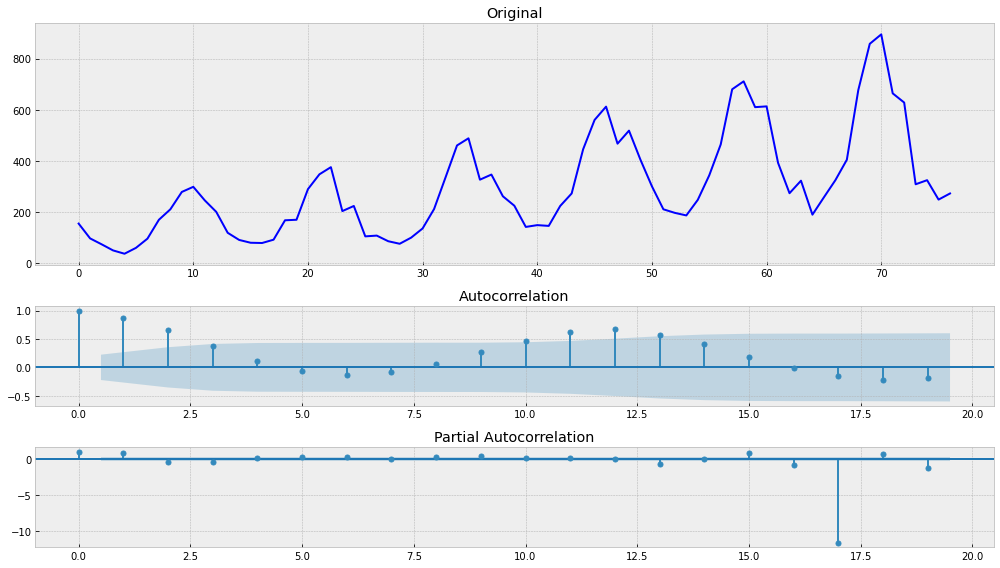

In [53]:
tsplot(sales_of_company_x_1)

Тест Дики-Фуллера и графики коррелограмм не отвергают гипотезу о нестационарности ряда. Ряд нестационарный.

Используем двойное экспоненциальное сглаживание, т.к.данный метод учитывает временной контекст и берёт в расчёт трендовую составляющую

In [54]:
def double_ema(series, alpha, beta):
    result = [series[0]]
    level, trend = series[0], series[1] - series[0]
    for n in range(1, len(series)):
        value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return pd.Series(result)

In [55]:
def plot_dema(alpha, beta):
    dema = double_ema(sales_of_company_x["Count"], alpha, beta)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(sales_of_company_x["Count"], color='blue',label='original')
        plt.plot(dema, color='red', linewidth='4', label='DEMA')
        plt.title("alpha={}, beta={}".format(alpha, beta))
        plt.legend()

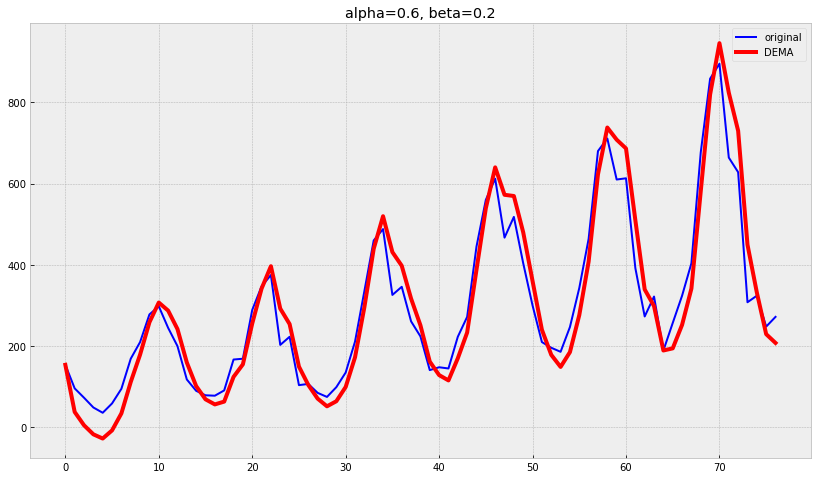

In [57]:
plot_dema(0.6, 0.2)

##### метод Хольт-Винтерса
Так же используем метод Хольт-Винтерса, т.к. данный метод учитывает временной контекст и берёт в расчёт трендовую составляющую

In [58]:
def initial_trend(series, season_len):
    return sum([float(series[i + season_len] - series[i]) / season_len]) / season_len

In [59]:
def initial_seasonal_components(series, slen):
    seasonals = {}
    season_averages = []
    n_seasons = int(len(series)/slen)
    # compute season averages
    for j in range(n_seasons):
        season_averages.append(sum(series[slen*j:slen*j+slen])/float(slen))
    # compute initial values
    for i in range(slen):
        sum_of_vals_over_avg = 0.0
        for j in range(n_seasons):
            sum_of_vals_over_avg += series[slen*j+i]-season_averages[j]
        seasonals[i] = sum_of_vals_over_avg/n_seasons
    return seasonals

In [60]:
def triple_exponential_smoothing(series, slen, alpha, beta, gamma, n_preds):
    result = []
    seasonals = initial_seasonal_components(series, slen)
    for i in range(len(series)+n_preds):
        if i == 0: # initial values
            smooth = series[0]
            trend = initial_trend(series, slen)
            result.append(series[0])
            continue
        if i >= len(series): # we are forecasting
            m = i - len(series) + 1
            result.append((smooth + m*trend) + seasonals[i%slen])
        else:
            val = series[i]
            last_smooth, smooth = smooth, alpha*(val-seasonals[i%slen]) + (1-alpha)*(smooth+trend)
            trend = beta * (smooth-last_smooth) + (1-beta)*trend
            seasonals[i%slen] = gamma*(val-smooth) + (1-gamma)*seasonals[i%slen]
            result.append(smooth+trend+seasonals[i%slen])
    return result

In [61]:
def plot_tema(alpha, beta, gamma, ser=sales_of_company_x["Count"], ser_to_plot=sales_of_company_x["Count"], n_preds=24):
    tema = triple_exponential_smoothing(ser, 12, alpha, beta, gamma, n_preds)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(ser_to_plot, color='blue',label='original')
        plt.plot(tema, color='red', linewidth='4', label='TEMA')
        plt.title("alpha={}, beta={}, gamma={}".format(alpha, beta, gamma))
        plt.legend()

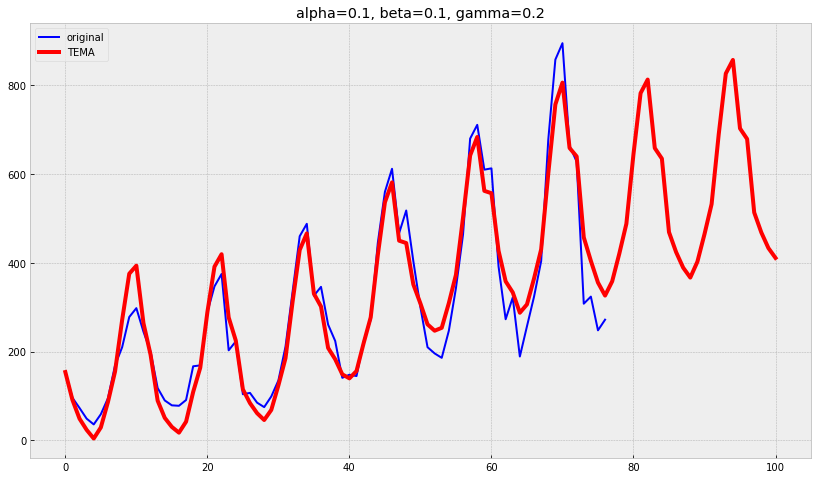

In [62]:
plot_tema(0.1, 0.1, 0.2)

##### Кросс-валидация

In [67]:
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error

In [68]:
series = sales_of_company_x["Count"]

In [69]:
train, val = series[:65], series[65:]

In [70]:
from sklearn.model_selection import TimeSeriesSplit

def mse_cross_val(X):
    alpha, beta, gamma = X
    split = TimeSeriesSplit(n_splits=3) 
    errors = []
    
    for train_split, test_split in split.split(train):
        train_split_ts = train.iloc[train_split]
        test_split_ts = train.iloc[test_split]
#         print(train_split_ts)
#         print(test_split_ts)
        result = triple_exponential_smoothing(train_split_ts, 12, alpha, beta, gamma, len(test_split))
        predictions = result[-len(test_split_ts):]
        error = mean_squared_error(predictions, test_split_ts)
        errors.append(error)
    print(f'{np.mean(np.array(errors))}------------')
    return np.mean(np.array(errors))

In [71]:
opt = minimize(mse_cross_val, x0=[0,0,0], method="Nelder-Mead", bounds = ((0, 1), (0, 1), (0, 1)))
# opt = minimize(mse_cross_val, x0=[0,0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1), (0, 1)))

C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_minimize.py:533: RuntimeWarning: Method Nelder-Mead cannot handle constraints nor bounds.
  warn('Method %s cannot handle constraints nor bounds.' % method,


34250.83897569433------------
34106.38472358218------------
34250.83897569433------------
34238.3901472449------------
34146.59424237435------------
34077.16559726701------------
33991.290217081325------------
33926.49661430412------------
33773.990957752445------------
33767.72957467019------------
33581.20293987484------------
33465.82461438681------------
33159.498375944626------------
33031.58107109831------------
32579.532037033798------------
32456.408928092------------
31845.128580818437------------
31553.720019486198------------
30680.50959062099------------
30356.192179879607------------
29199.04793100106------------
28811.08518833116------------
27409.489766671828------------
26926.77963532865------------
25448.607557974843------------
24855.649000990146------------
23442.82600112662------------
23241.208137677953------------
22754.939827298327------------
22871.812074651574------------
23486.470097726604------------
22758.476763741895------------
24772.198480753606----------

7550.119155918743------------
7549.405206286462------------
7544.973349313361------------
7543.745028802085------------
7560.524672357108------------
7546.757394802546------------
7543.226466947857------------
7542.846922275687------------
7540.004710656023------------
7537.342755748033------------
7538.7698550708565------------
7537.0611177204------------
7539.4557953168------------
7541.217928953825------------
7534.572111002742------------
7538.924823704086------------
7535.6482009536385------------
7539.037211987987------------
7535.2808022040845------------
7539.518260592861------------
7534.958398217134------------
7533.5684904109485------------
7533.501609204654------------
7532.497076227307------------
7533.456195830434------------
7532.061486415475------------
7535.233263326969------------
7531.17379691121------------
7532.514711294053------------
7533.718379830111------------
7531.94332863165------------
7530.701696904878------------
7531.615000837908------------
7536.0229478

7501.788230968604------------
7501.789377585727------------
7501.883830446329------------
7501.814927042956------------
7501.758000555145------------
7501.7551791313745------------
7501.774093887478------------
7501.6858475238------------
7501.633543131472------------
7501.8762009964985------------
7501.73060144412------------
7501.668073652639------------
7501.654690297563------------
7501.567798337751------------
7501.52008866756------------
7501.51063106053------------
7501.452046631007------------
7501.506818032706------------
7501.431233571111------------
7501.8666540058975------------
7501.402795803868------------
7501.541497918514------------


In [72]:
alpha_opt, beta_opt, gamma_opt = opt.x
print(opt)

 final_simplex: (array([[2.53208067e-04, 2.37706597e+01, 8.93829054e-01],
       [2.51248055e-04, 2.38649783e+01, 8.98217311e-01],
       [2.68517229e-04, 2.25784336e+01, 8.95060656e-01],
       [2.60185750e-04, 2.30852300e+01, 8.96501177e-01]]), array([7501.4027958 , 7501.43123357, 7501.45204663, 7501.50681803]))
           fun: 7501.402795803868
       message: 'Maximum number of function evaluations has been exceeded.'
          nfev: 600
           nit: 350
        status: 1
       success: False
             x: array([2.53208067e-04, 2.37706597e+01, 8.93829054e-01])


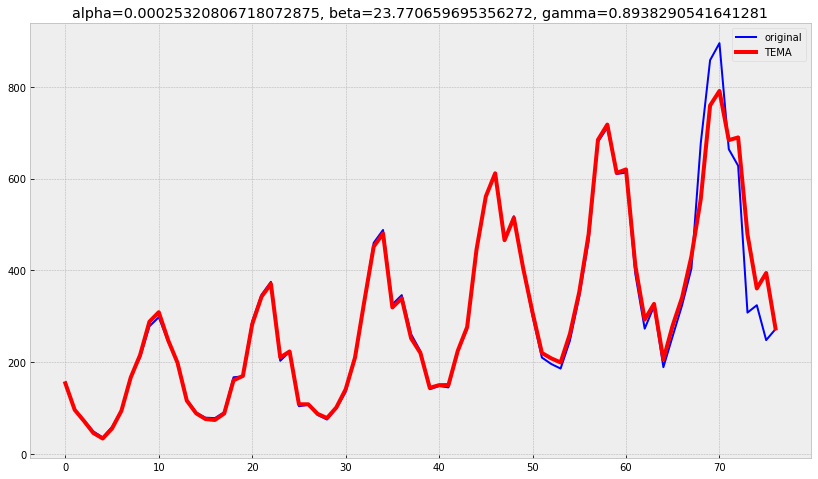

In [73]:
plot_tema(alpha_opt, beta_opt, gamma_opt, ser=train, ser_to_plot=series, n_preds=len(val))